In [5]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

ONLY RUN WHEN IMAGE RGB+FLIPPED IMAGE READY
ALSO PREPROCESS THE IMAGE AND THEIR KEYPOINTS ARE SAVED INTO TH CSV

In [99]:
# # Download model from TF Hub and check out inference code from GitHub
# # https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
# !git clone https://github.com/tensorflow/examples.git
# pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
# sys.path.append(pose_sample_rpi_path)

In [6]:
# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

In [7]:
# Define function to run pose estimation using MoveNet Thunder.
# You'll apply MoveNet's cropping algorithm and run inference multiple times on
# the input image to improve pose estimation accuracy.
def detect(input_tensor, inference_count=3):
  """Runs detection on an input image.
 
  Args:
    input_tensor: A [height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.
    inference_count: Number of times the model should run repeatly on the
      same input image to improve detection accuracy.
 
  Returns:
    A Person entity detected by the MoveNet.SinglePose.
  """
  image_height, image_width, channel = input_tensor.shape
 
  # Detect pose using the full input image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)
 
  # Repeatedly using previous detection result to identify the region of
  # interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(), 
                            reset_crop_region=False)

  return person

In [8]:
#@title Functions to visualize the pose estimation results.

def draw_prediction_on_image(
    image, person, crop_region=None, close_figure=True,
    keep_input_size=False):
  """Draws the keypoint predictions on image.
 
  Args:
    image: An numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    person: A person entity returned from the MoveNet.SinglePose model.
    close_figure: Whether to close the plt figure after the function returns.
    keep_input_size: Whether to keep the size of the input image.
 
  Returns:
    An numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  # Draw the detection result on top of the image.
  image_np = utils.visualize(image, [person])
  
  # Plot the image with detection results.
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  im = ax.imshow(image_np)
 
  if close_figure:
    plt.close(fig)
 
  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np

In [9]:
#@title Code to load the images, detect pose landmarks and save them into a CSV file

class MoveNetPreprocessor(object):
  """Helper class to preprocess pose sample images for classification."""
 
  def __init__(self,
               images_in_folder,
               images_out_folder,
               csvs_out_path):
    """Creates a preprocessor to detection pose from images and save as CSV.

    Args:
      images_in_folder: Path to the folder with the input images. It should
        follow this structure:
        yoga_poses
        |__ downdog
            |______ 00000128.jpg
            |______ 00000181.bmp
            |______ ...
        |__ goddess
            |______ 00000243.jpg
            |______ 00000306.jpg
            |______ ...
        ...
      images_out_folder: Path to write the images overlay with detected
        landmarks. These images are useful when you need to debug accuracy
        issues.
      csvs_out_path: Path to write the CSV containing the detected landmark
        coordinates and label of each image that can be used to train a pose
        classification model.
    """
    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_path = csvs_out_path
    self._messages = []

    # Create a temp dir to store the pose CSVs per class
    self._csvs_out_folder_per_class = tempfile.mkdtemp()
 
    # Get list of pose classes and print image statistics
    self._pose_class_names = sorted(
        [n for n in os.listdir(self._images_in_folder) if not n.startswith('.')]
        )
    
  def process(self, per_pose_class_limit=None, detection_threshold=0.1):
    """Preprocesses images in the given folder.
    Args:
      per_pose_class_limit: Number of images to load. As preprocessing usually
        takes time, this parameter can be specified to make the reduce of the
        dataset for testing.
      detection_threshold: Only keep images with all landmark confidence score
        above this threshold.
    """
    # Loop through the classes and preprocess its images
    for pose_class_name in self._pose_class_names:
      print('Preprocessing', pose_class_name, file=sys.stderr)

      # Paths for the pose class.
      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  pose_class_name + '.csv')
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)
 
      # Detect landmarks in each image and write it to a CSV file
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, 
                                    delimiter=',', 
                                    quoting=csv.QUOTE_MINIMAL)
        # Get list of images
        image_names = sorted(
            [n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          image_names = image_names[:per_pose_class_limit]

        valid_image_count = 0
 
        # Detect pose landmarks from each image
        for image_name in tqdm.tqdm(image_names):
          image_path = os.path.join(images_in_folder, image_name)

          try:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
          except:
            self._messages.append('Skipped ' + image_path + '. Invalid image.')
            continue
          else:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
            image_height, image_width, channel = image.shape
          
          # Skip images that isn't RGB because Movenet requires RGB images
          if channel != 3:
            self._messages.append('Skipped ' + image_path +
                                  '. Image isn\'t in RGB format.')
            continue
          person = detect(image)
          
          # Save landmarks if all landmarks were detected
          min_landmark_score = min(
              [keypoint.score for keypoint in person.keypoints])
          should_keep_image = min_landmark_score >= detection_threshold
          if not should_keep_image:
            self._messages.append('Skipped ' + image_path +
                                  '. No pose was confidentlly detected.')
            continue

          valid_image_count += 1

          # Draw the prediction result on top of the image for debugging later
          output_overlay = draw_prediction_on_image(
              image.numpy().astype(np.uint8), person, 
              close_figure=True, keep_input_size=True)
        
          # Write detection result into an image file
          output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)
        
          # Get landmarks and scale it to the same size as the input image
          pose_landmarks = np.array(
              [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                for keypoint in person.keypoints],
              dtype=np.float32)

          # Write the landmark coordinates to its per-class CSV file
          coordinates = pose_landmarks.flatten().astype(np.str).tolist()
          csv_out_writer.writerow([image_name] + coordinates)

        if not valid_image_count:
          raise RuntimeError(
              'No valid images found for the "{}" class.'
              .format(pose_class_name))
      
    # Print the error message collected during preprocessing.
    print('\n'.join(self._messages))

    # Combine all per-class CSVs into a single output file
    all_landmarks_df = self._all_landmarks_as_dataframe()
    all_landmarks_df.to_csv(self._csvs_out_path, index=False)

  def class_names(self):
    """List of classes found in the training dataset."""
    return self._pose_class_names
  
  def _all_landmarks_as_dataframe(self):
    """Merge all per-class CSVs into a single dataframe."""
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  class_name + '.csv')
      per_class_df = pd.read_csv(csv_out_path, header=None)
      
      # Add the labels
      per_class_df['class_no'] = [class_index]*len(per_class_df)
      per_class_df['class_name'] = [class_name]*len(per_class_df)

      # Append the folder name to the filename column (first column)
      per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '') 
        + per_class_df[per_class_df.columns[0]].astype(str))

      if total_df is None:
        # For the first class, assign its data to the total dataframe
        total_df = per_class_df
      else:
        # Concatenate each class's data into the total dataframe
        total_df = pd.concat([total_df, per_class_df], axis=0)
 
    list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
                  bodypart.name + '_score'] for bodypart in BodyPart] 
    header_name = []
    for columns_name in list_name:
      header_name += columns_name
    header_name = ['file_name'] + header_name
    header_map = {total_df.columns[i]: header_name[i] 
                  for i in range(len(header_name))}
 
    total_df.rename(header_map, axis=1, inplace=True)

    return total_df

In [104]:
# # # Dateset image processing

# # from split import split_into_train_test
# # use_custom_dataset = True
# # dataset_is_split = False

# # if use_custom_dataset:
# #   # ATTENTION:
# #   # You must edit these two lines to match your archive and images folder name:
# #   # !tar -xf YOUR_DATASET_ARCHIVE_NAME.tar
# #   # dataset_in = 'yoga_poses'
# #   dataset_in = 'total_rgb_flip'
  
# #   # You can leave the rest alone:
# #   if not os.path.isdir(dataset_in):
# #     raise Exception("dataset_in is not a valid directory")
# #   if dataset_is_split:
# #     IMAGES_ROOT = dataset_in
# #   else:
# #     dataset_out = 'split_' + dataset_in
# #     split_into_train_test(dataset_in, dataset_out, test_split=0.2)
# #     IMAGES_ROOT = dataset_out
# dataset_is_split=True
# if dataset_is_split:
#     dataset_in = 'split_total_rgb_flip'
#     IMAGES_ROOT = dataset_in

In [10]:
  # images_in_train_folder = os.path.join(IMAGES_ROOT, 'train')
  # images_out_train_folder = 'poses_images_out_train'
  csvs_out_train_path = 'train_data.csv'

  # preprocessor = MoveNetPreprocessor(
  #     images_in_folder=images_in_train_folder,
  #     images_out_folder=images_out_train_folder,
  #     csvs_out_path=csvs_out_train_path,
  # )

  # preprocessor.process(per_pose_class_limit=None)

In [11]:
  # images_in_test_folder = os.path.join(IMAGES_ROOT, 'test')
  # images_out_test_folder = 'poses_images_out_test'
  csvs_out_test_path = 'test_data.csv'

  # preprocessor = MoveNetPreprocessor(
  #     images_in_folder=images_in_test_folder,
  #     images_out_folder=images_out_test_folder,
  #     csvs_out_path=csvs_out_test_path,
  # )

  # preprocessor.process(per_pose_class_limit=None)

In [12]:
def load_pose_landmarks(csv_path):
  """Loads a CSV created by MoveNetPreprocessor.

  Returns:
    X: Detected landmark coordinates and scores of shape (N, 17 * 3)
    y: Ground truth labels of shape (N, label_count)
    classes: The list of all class names found in the dataset
    dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
      truth labels (y) to use later to train a pose classification model.
  """

  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe

In [108]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(csvs_out_train_path)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.15)

In [109]:
# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

In [2]:
import converter
#importing functions to convert the pose landmarks to a pose embedding (a.k.a. feature vector) for pose classification

# Next, convert the landmark coordinates to a feature vector by:

# Moving the pose center to the origin.
# Scaling the pose so that the pose size becomes 1
# Flattening these coordinates into a feature vector
# Then use this feature vector to train a neural-network based pose classifier.

In [34]:
def load_csv(csv_path):
    df = pd.read_csv(csv_path)
    df.drop(['file_name'],axis=1, inplace=True)
    classes = df.pop('class_name').unique()
    y = df.pop('class_no')
    
    X = df.astype('float64')
    y = keras.utils.to_categorical(y)
    
    return X, y, classes

def preprocess_data(X_train):
    processed_X_train = []
    for i in range(X_train.shape[0]):
        embedding = converter.landmarks_to_embedding(tf.reshape(tf.convert_to_tensor(X_train.iloc[i]), (1, 51)))
        processed_X_train.append(tf.reshape(embedding, (34)))
    return tf.convert_to_tensor(processed_X_train)

In [31]:
X, y, class_names = load_csv(csvs_out_train_path)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)
X_test, y_test, _ = load_csv(csvs_out_test_path)

In [35]:
processed_X_train = preprocess_data(X_train)
processed_X_val =  preprocess_data(X_val)
processed_X_test = preprocess_data(X_test)

In [36]:
# Define the model
inputs = tf.keras.Input(shape=(34))
# embedding = converter.landmarks_to_embedding(inputs)

# layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dense(128, activation=tf.nn.relu6)(inputs)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense_3 (Dense)             (None, 128)               4480      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 12,931
Trainable params: 12,931
Non-trainable

In [37]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
if os.path.exists(checkpoint_path):
  os.remove(checkpoint_path)
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
history = model.fit(processed_X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(processed_X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
 1/13 [=>............................] - ETA: 4s - loss: 1.1490 - accuracy: 0.3750
Epoch 00001: val_accuracy improved from -inf to 0.77143, saving model to weights.best.hdf5
13/13 [==============================] - 1s 14ms/step - loss: 1.0839 - accuracy: 0.4490 - val_loss: 1.0089 - val_accuracy: 0.7714
Epoch 2/200
 1/13 [=>............................] - ETA: 0s - loss: 1.0074 - accuracy: 0.6250
Epoch 00002: val_accuracy improved from 0.77143 to 0.91429, saving model to weights.best.hdf5
13/13 [==============================] - 0s 4ms/step - loss: 0.9977 - accuracy: 0.6378 - val_loss: 0.9064 - val_accuracy: 0.9143
Epoch 3/200
 1/13 [=>............................] - ETA: 0s - loss: 0.9110 - accuracy: 0.7500
Epoch 00003: val_accuracy did not improve from 0.91429
13/13 [==============================] - 0s 3ms/step - loss: 0.8930 - accuracy: 0.7041 - val_loss: 0.7987 - val_accuracy: 0.8286
Epoch 4/200
 1/13 [=>............................] - ETA: 0s - loss: 0.8183 - accuracy:

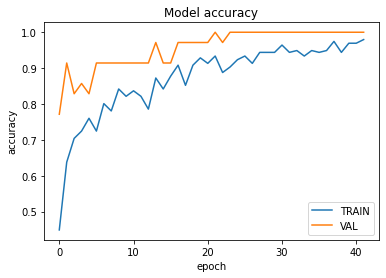

In [38]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [39]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(processed_X_test, y_test)
print('LOSS: ', loss)
print("ACCURACY: ", accuracy)

2/2 [==============================] - 0s 3ms/step - loss: 0.0295 - accuracy: 1.0000
LOSS:  0.029541000723838806
ACCURACY:  1.0


In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(processed_X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

Confusion matrix, without normalization

Classification Report:
                 precision    recall  f1-score   support

      Mountain       1.00      1.00      1.00        17
SleepingVishnu       1.00      1.00      1.00        16
          Tree       1.00      1.00      1.00        24

      accuracy                           1.00        57
     macro avg       1.00      1.00      1.00        57
  weighted avg       1.00      1.00      1.00        57



Convert the pose classification model to TensorFlow Lite

In [116]:
# converterToJS = tf.lite.TFLiteConverter.from_keras_model(model)
# converterToJS.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_model = converterToJS.convert()

# print('Model size: %dKB' % (len(tflite_model) / 1024))

# with open('pose_classifier.tflite', 'wb') as f:
#   f.write(tflite_model)

In [117]:
# # Then you'll write the label file which contains mapping from the class indexes to the human readable class names.
# with open('pose_labels.txt', 'w') as f:
#   f.write('\n'.join(class_names))

In [42]:
tfjs_model_dir = 'model'
if not os.path.exists(tfjs_model_dir):
        os.makedirs(tfjs_model_dir)

import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, tfjs_model_dir)
print('tfjs model saved at ',tfjs_model_dir)

tfjs model saved at  model
